# Class Project

### Phyllis Kho

## Introduction

Local coral biologists in Florida claim that groundwater input into the ocean is high. If so, sea surface salinity (SSS) of the waters that the corals grow in should decrease with increasing groundwater input. SSS is primarily influenced by precipitation but can be affected more greatly by groundwater input if it is significant enough. Here, I aim to look at the variations in precipitation and SSS from 2018 to 2023 to see how SSS and precipitation trend (or do not trend) together in Florida. In general, greater precipitation results in lower SSS and vice versa. Unfortunately, groundwater input data is unavailable.

In [21]:
import xarray as xr
import numpy as np
from matplotlib import pyplot as plt
import cartopy.crs as ccrs
import os
from scipy.stats import pearsonr
import calendar
import warnings
warnings.filterwarnings('ignore')
import glob
import zipfile

In [ ]:
# Unzip files containing SSS data

# Path to the directory containing the ZIP files
#directory_path = '/home/pyk2106/pyk2106/ENData/'

# Pattern matching the ZIP files (e.g., 'EN.4.2.2.analyses.c14.*.zip')
#zip_file_pattern = 'EN.4.2.2.analyses.c14.*.zip'

# Get a list of all matching ZIP files
#zip_files = glob.glob(f'{directory_path}{zip_file_pattern}')

# Create a directory to extract the netCDF files
#extraction_dir = 'extracted_files'
#os.makedirs(extraction_dir, exist_ok=True)

# Extract each netCDF file from the ZIP archives
#for zip_file in zip_files:
   # with zipfile.ZipFile(zip_file, 'r') as zip_ref:
        #zip_ref.extractall(extraction_dir)

# Open all extracted netCDF files using xarray's open_mfdataset
#EN = xr.open_mfdataset(f'{extraction_dir}/*.nc', engine='netcdf4', combine='by_coords')

In [22]:
EN = xr.open_mfdataset('/home/pyk2106/pyk2106/ENData/extracted_files/EN.4.2.2.f.analysis.c14.*.nc')

In [23]:
# Slice salinity, depth, lat and lon in EN data to get only SSS data in Florida
SSS = EN.salinity.sel(lat=slice(20, 35), lon=slice(270, 290), time=slice('2018-01-01', '2023-12-31')).isel(depth=0)

In [24]:
# Open precipitation data
precip_download = '/home/pyk2106/precip.mon.mean.nc'
precip_ds = xr.open_dataset(precip_download)

# Slide precipitation data for Florida
precip = precip_ds.precip.sel(lat=slice(20, 35), lon=slice(270, 290), time=slice('2018-01-01', '2023-12-31'))

In [25]:
# Calculate average precipitation and SSS over space
precip_clim = precip.mean(dim=('lat', 'lon'))
SSS_clim = SSS.mean(dim=('lat', 'lon'))

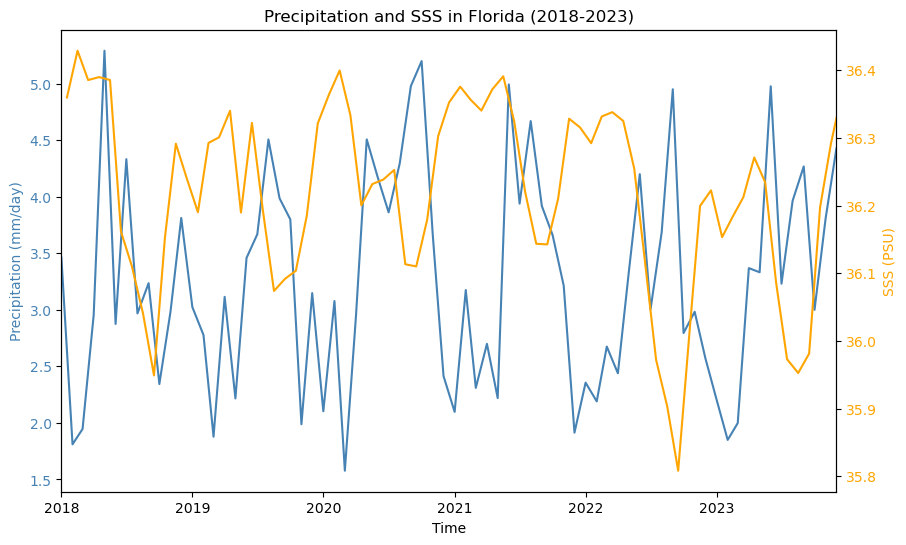

In [26]:
# Create a new figure and axis sharing the same x-axis
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot precipitation on the primary y-axis
ax1.plot(precip_clim.time, precip_clim, color='steelblue')
ax1.set_xlabel('Time')
ax1.set_ylabel('Precipitation (mm/day)', color='steelblue')
ax1.set_title('Precipitation and SSS in Florida (2018-2023)')
ax1.tick_params(axis='y', labelcolor='steelblue')
ax1.set_xlim(precip_clim.time.min(), precip_clim.time.max())

# Create a secondary y-axis for SSS
ax2 = ax1.twinx()
ax2.plot(SSS_clim.time, SSS_clim, color='orange')
ax2.set_ylabel('SSS (PSU)', color='orange')
ax2.tick_params(axis='y', labelcolor='orange')

In [27]:
# Calculate standard deviation and mean of precipitation and SSS over each month
precip_sd = precip_clim.groupby('time.month').std()
precip_mean = precip_clim.groupby('time.month').mean()
SSS_sd = SSS_clim.groupby('time.month').std()
SSS_mean = SSS_clim.groupby('time.month').mean()

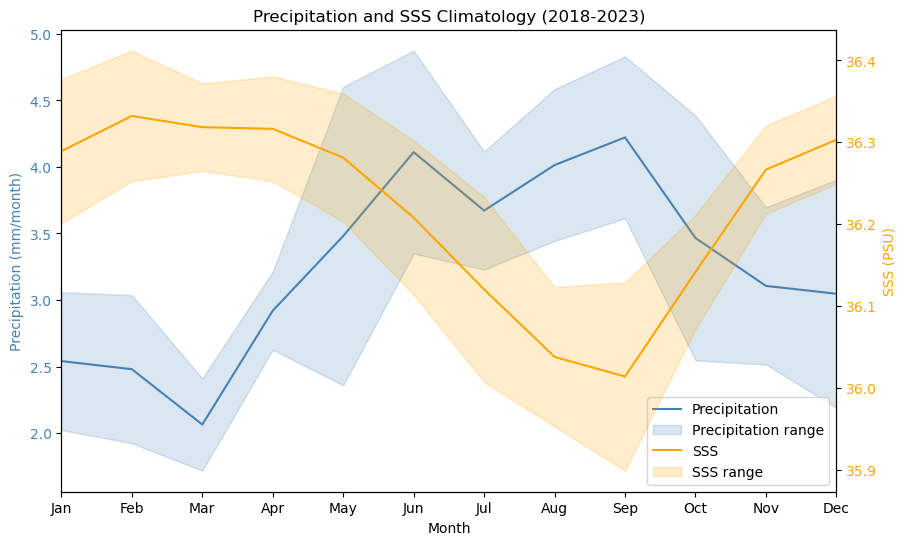

In [28]:
 # Create a new figure and axis sharing the same x-axis
fig, ax1 = plt.subplots(figsize=(10, 6));
    
# Define the x-axis values (months) and use abbreviations for each month
months = range(1, 13);
month_names = [calendar.month_abbr[m] for m in months] ;
    
# Plot precipitation on the primary y-axis
#ax1.errorbar(months, precip_mean, yerr=precip_sd, capsize=3, ecolor='grey', color='steelblue', label='Precipitation');
ax1.plot(months, precip_mean, linestyle='-', color='steelblue', label ="Precipitation");
ax1.fill_between(months, precip_mean+precip_sd, precip_mean-precip_sd, color='steelblue', alpha=0.2, label ="Precipitation range");
ax1.set_xlabel('Month');
ax1.set_xlim(months[0], months[-1]);
ax1.set_xticks(months);
ax1.set_xticklabels(month_names); 
ax1.set_ylabel('Precipitation (mm/month)', color='steelblue');
ax1.tick_params(axis='y', labelcolor='steelblue');
ax1.set_title('Precipitation and SSS Climatology (2018-2023)');


    
# Create a secondary y-axis for SSS
ax2 = ax1.twinx();
#ax2.errorbar(months, SSS_mean, yerr=SSS_sd, capsize=3, ecolor='black', color='orange', label='SSS')
ax2.plot(months, SSS_mean, linestyle='-', color='orange', label = "SSS");
ax2.fill_between(months, SSS_mean+SSS_sd, SSS_mean-SSS_sd, color='orange', alpha=0.2, label = "SSS range");
ax2.set_ylabel('SSS (PSU)', color='orange');
ax2.tick_params(axis='y', labelcolor='orange');


lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='lower right')

In [29]:
# Convert DataArrays to numpy arrays for correlation calculation
SSS_array = SSS_clim.values
precip_array = precip_clim.values

# Calculate Pearson correlation coefficient and p-value
correlation_coefficient, p_value = pearsonr(SSS_array, precip_array)

# Calculate linear regression parameters
slope, intercept = np.polyfit(SSS_array, precip_array, 1)

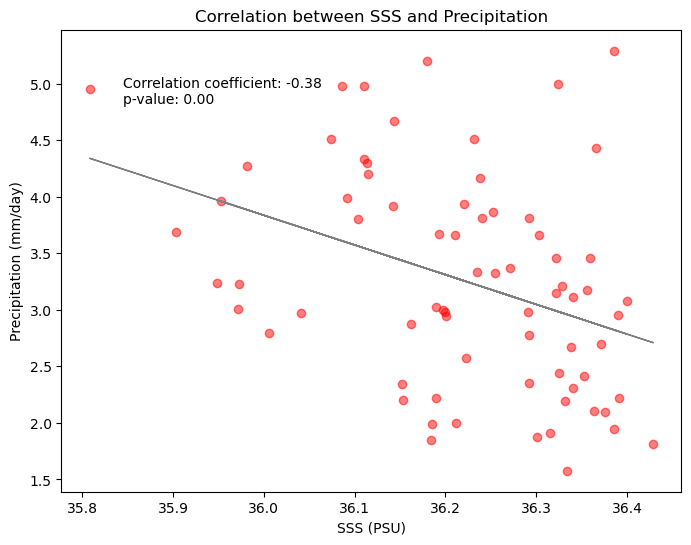

In [30]:
# Create scatter plot
plt.figure(figsize=(8, 6));
plt.scatter(SSS_array, precip_array, color='red', alpha=0.5, label='Data');

# Plot best-fit line
plt.plot(SSS_array, slope * SSS_array + intercept, color='grey', linewidth=1, linestyle='solid');

# Add labels and title
plt.xlabel('SSS (PSU)');
plt.ylabel('Precipitation (mm/day)');
plt.title('Correlation between SSS and Precipitation');

# Add correlation coefficient and p-value to plot
plt.text(0.1, 0.9, f'Correlation coefficient: {correlation_coefficient:.2f}\np-value: {p_value:.2f}',
         transform=plt.gca().transAxes, fontsize=10, verticalalignment='top');

In [18]:
correlation_coefficient, p_value

(-0.3780805138989564, 0.0010587749509363242)

In [19]:
slope, intercept

(-2.6269085207566434, 98.40441070334332)

Without groundwater data, it is impossible to preclude that groundwater input does not exert any influence on SSS values. However, it seems that precipitation plays a prominent role in influencing SSS values, as indicated by the clear inverse relationship between the two throughout the entire study period, 2018-2023. 